<a href="https://colab.research.google.com/github/zrosen3/Colombian-peso-counterfeit-detection/blob/main/Code/log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [1]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
%cd /content/Colombian-peso-counterfeit-detection/Code       

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 21315, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 21315 (delta 211), reused 238 (delta 138), pack-reused 20965
Receiving objects: 100% (21315/21315), 441.40 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Updating files: 100% (62418/62418), done.
/content/Colombian-peso-counterfeit-detection/Code


In [2]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
from PIL import Image
import seaborn as sns
import common_functions as cf


#Load in data

In [3]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData()


Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


## Run logistic regression model

In [4]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(480, 640, 3)),
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(
                units = 13,
               activation = "softmax"
        )])
        
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=1)

390/390 [==============================] - 223s 568ms/step - loss: 30.4122 - accuracy: 0.5232 - val_loss: 16.5795 - val_accuracy: 0.6526


## Inspect model performance

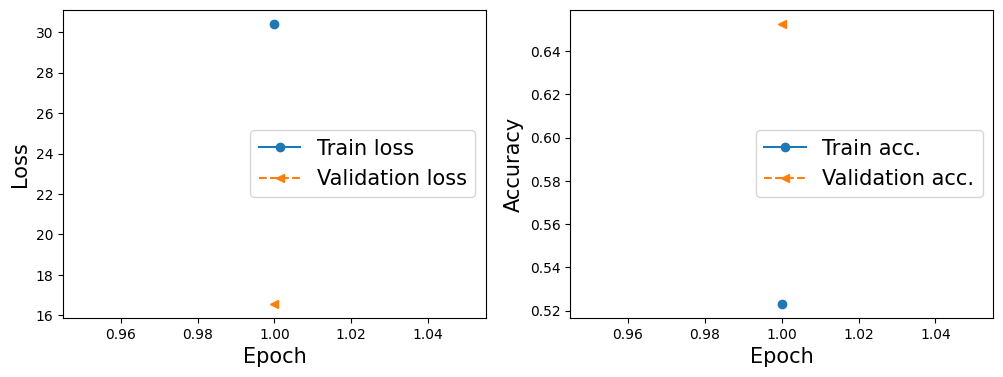

130/130 - 22s - loss: 16.0556 - accuracy: 0.6620 - 22s/epoch - 172ms/step
Test loss: 16.05558204650879 | Test accuracy: 0.6620192527770996


(0.5231989622116089, 0.6526442170143127, 0.6620192527770996)

In [5]:
cf.EvaluateModel(model, test_ds, history)

In [6]:
y_pred_probs, y_test, y_pred = cf.ExtractPredictions(model, test_ds)

TypeError: ignored

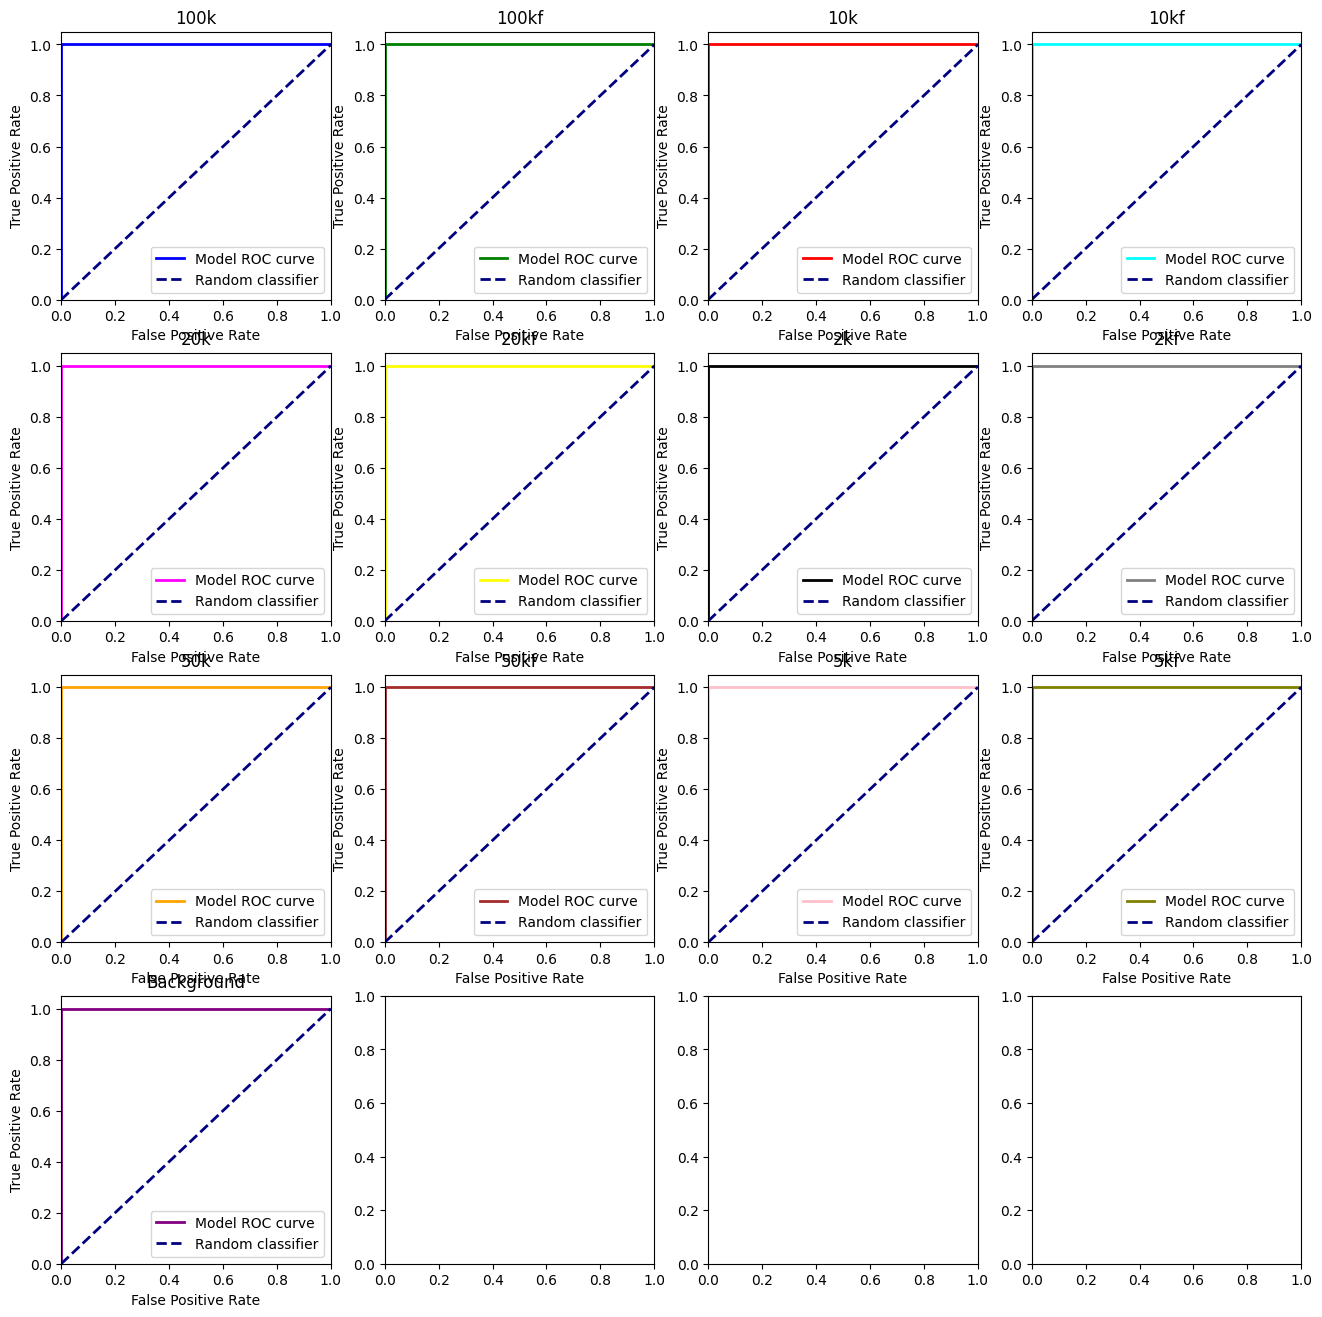

In [9]:
#cf.PrecisionRecallScores(y_test, y_pred) #seems to be working
#cf.ConfusionMatrix(class_names, y_test, y_pred) #seems to be working
cf.ROCPlots(y_pred_probs, y_test, y_pred, class_names)
